In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

In [2]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)

## 0.0.1 Import Data

In [3]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [4]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
print("X shape:",X.shape)
print("y shape:",y.shape)
print("Min y:",min(np.array(y))[0])
print("Max y:",max(np.array(y))[0])

X shape: (264, 1135)
y shape: (264, 1)
Min y: 0.0117532464005208
Max y: 4.9270454514617015


## 0.0.2 Visualize our data

We would like to visualize how the values of the output are distributed, using a histogram. 

Since our output values range from 0.01 to 4.92, it makes sense to display our output in bins from [0-1] to [4-5]

Text(0.5, 1.0, 'Output Distribution')

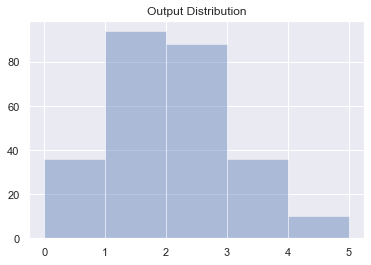

In [5]:
sns.distplot(y,bins=[0,1,2,3,4,5],kde=False)
plt.title("Output Distribution")


Remark: Most of our values falls within [1-3]. The highest yields [4-5], unsurprisingly, are the fewest

## 0.0.3 Construct a Scoring system

### i- Scorer class
First construct a scoring class. This will keep track of all our scores.

In [6]:
class ScoreSheet:
    def __init__(self,title):
        self.title=title
        self.sheet = pd.DataFrame({})
        
    def add_score(self,name,list):
        self.sheet.loc[name]=list
        
    def add_score(self,series):
        self.sheet = self.sheet.append(series)
        
    def get_pred_labels(self):
        return list(self.sheet.columns)
    
    def get_test_labels(self):
        return list(self.sheet.index)
    
    def get_test(self,name):
        return self.sheet.loc[name]
    
    def get_predictor(self,name):
        return list(self.sheet[name])
    
    def get_sheet(self):
        return self.sheet
    
    

### ii - Drawer class

This class will help with the plotting of graphs in the ScoreSheet and Test

- v1.0

In [7]:
class Draw:
    
    def histogram(train_sr,test_sr):
        sns.distplot(train_sr['y_train'],bins=[0,1,2,3,4,5],kde=True)
        sns.distplot(test_sr['y_test'],bins=[0,1,2,3,4,5],kde=True)
    
    def heatmap(ss):
        ax=sns.heatmap(ss.get_sheet(),annot=True, fmt=".3f",cmap="coolwarm", center = -0.1 ,
                       square = True,linewidths=.1,vmin=-1,vmax=1,cbar=False)
        plt.title(ss.title)
    
    def lineplot(ss,cols):
        ax = plt.subplot()
        for name in cols:
            x = ss.get_test_labels()
            y = ss.get_predictor(name)
            plt.plot(x,y)
            ax.set_ylim([0.0,1.0])
        ax.legend()
        plt.show()
    
    def scatterplot(train_series,test_series):
#         plt.subplot()
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        y_train,y_train_predicted = train_series["y_train"],train_series["y_train_predicted"]
        y_test, y_test_predicted  = test_series["y_test"], test_series["y_test_predicted"]
        plt.plot(y_train, y_train_predicted, 'x', color='red')
        plt.plot(y_test,y_test_predicted, 'o', color='black')
        plt.plot(np.linspace(0,5,10),np.linspace(0,5,10),'b--')
        plt.show()

### iii - Test class

In [8]:
from random import random
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  


class Test:
    def __init__(self,X,y):
        self.settings = Settings(X,y,0.2,None)
        
    def get_settings(self):
        return self.settings
    
    def set_settings(self,settings):
        self.settings = settings
  
    
    def train_test(self,clf_name):
        setg = self.get_settings()
        clf = setg.predictor(clf_name)
        if setg.bias > 0:
            X_train, X_test, y_train, y_test = setg.biased_split()
        else:
            X_train, X_test, y_train, y_test = train_test_split(setg.X,setg.y,test_size=setg.split,stratify=setg.strf)
        clf.fit(X_train,y_train)
        y_train_predicted = clf.predict(X_train)
        y_test_predicted  = clf.predict(X_test)
        return pd.Series([X_train, y_train, y_train_predicted],index=["X_train", "y_train", "y_train_predicted"],name="Training Series"
                        ),pd.Series([X_test, y_test, y_test_predicted],index=["X_test", "y_test", "y_test_predicted"],name="Testing Series")
        
    # Determine the R2 Score for a list of predictors
    def R2(self,predictors):
        train_r2 = []
        test_r2 = []
        for clf_name in predictors:
            train_sr, test_sr = self.train_test(clf_name)
            
            y_train,y_train_predicted = train_sr["y_train"],train_sr["y_train_predicted"]
            y_test, y_test_predicted  = test_sr["y_test"], test_sr["y_test_predicted"]
            
            train_r2.append(r2_score(y_train,y_train_predicted))
            test_r2.append(r2_score(y_test,y_test_predicted))
        return pd.Series(train_r2,index=predictors,name="Train R2"),pd.Series(test_r2,index=predictors,name="Test R2")
    
    def R2_avg(self,predictors,iterations):
        all_train_r2 = []
        all_test_r2 = []
        for i in range(iterations):
            train_r2,test_r2 = self.R2(predictors)
            all_train_r2.append(list(train_r2))
            all_test_r2.append(list(test_r2))
        mean_train_r2 = [np.mean(i) for i in np.array(all_train_r2).T]
        mean_test_r2 = [np.mean(i) for i in np.array(all_test_r2).T]
        return pd.Series(mean_train_r2,index=predictors,name="Train R2"),pd.Series(mean_test_r2,index=predictors,name="Test R2")
    
    

### iv - Settings class

Keep track of all the settings and predictors including split_size, stratification option, grid search, etc...

In [48]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

class Settings:
    def __init__(self,X,y,split,stratify):
        self.X = X
        self.y = y
        self.strf = stratify
        self.split = split
        self.bias = 0
        self.bias_threshold = 3
    def predictor(self,clf_name):
        pred = {"SVR":SVR(),'RFR':RandomForestRegressor(),
               "XGB":XGBRegressor(),"ADA":AdaBoostRegressor()}
        return pred[clf_name]
    
    def get_stratify(self):
        return self.strf
    
    def set_stratify(self,bool):
        if bool:
            self.strf = np.array(self.y,dtype="int")
        else:
            self.strf = None
            
    def get_y_stratified(self,y):
        return np.array(y,dtype="int")
    

    def set_split(self,split):
        self.split = split
        
    def get_split(self):
        return self.split
    
    def set_bias(self,bias):
        self.bias = bias
            
    def biased_split(self):
        filt1 = raw_data["output"] >= self.bias_threshold #Filter out outputs that are higher than 3
        filt2 = raw_data["output"] < self.bias_threshold
        df1 = raw_data[filt1]
        df2 = raw_data[filt2]

        X_021a = df1.iloc[:,1:-1]
        y_021a = df1.iloc[:,-1:]
        X_021b = df2.iloc[:,1:-1]
        y_021b = df2.iloc[:,-1:]

        X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_021a,y_021a,test_size=self.bias,
                                                        stratify=np.array(y_021a,dtype="int"))
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_021b,y_021b,test_size=self.split,
                                                        stratify=np.array(y_021b,dtype="int"))

        y_train = y_train_a.append(y_train_b)
        X_train = X_train_a.append(X_train_b)
        y_test = y_test_a.append(y_test_b)
        X_test = X_test_a.append(X_test_b)

        return X_train, X_test, y_train, y_test
    
    def print_settings(self):
        print(self.split,
            self.bias,
            self.bias_threshold)

## 0.1.0 Raw R2 Score

In [49]:
test01 = Test(X,y)

ss = ScoreSheet("Raw R2 Score")
train_sr,test_sr = test01.R2(["ADA","RFR","SVR","XGB"])
ss.add_score(train_sr)
ss.add_score(test_sr)
print(ss.title)
ss.get_sheet().head()

Raw R2 Score


,ADA,RFR,SVR,XGB
Train R2,0.748297,0.860691,0.725183,1.000000
Test R2,0.122983,0.045867,0.185964,-0.042949


In [50]:
test = Test(X,y)
train_avg,test_avg = test.R2_avg(["ADA","RFR","SVR","XGB"],5)
ss = ScoreSheet("Average Raw R2")
ss.add_score(train_avg)
ss.add_score(test_avg)
print(ss.title)
ss.get_sheet().head()

Average Raw R2


,ADA,RFR,SVR,XGB
Train R2,0.742999,0.821232,0.735481,1.000000
Test R2,0.023531,0.059136,0.223827,0.075187


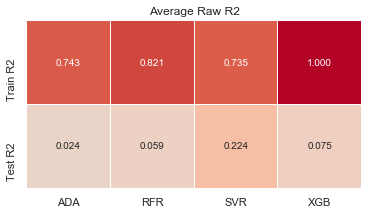

In [51]:
Draw.heatmap(ss)

In [52]:
test.settings.bias

0

## 0.2.0 Stratify our Data

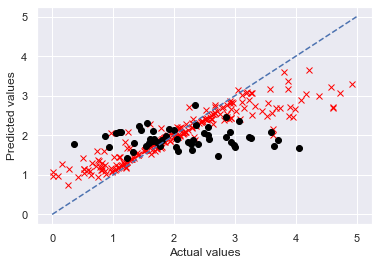

train_r2 0.7438409121535021
test_r2 -0.1357101569753134


In [53]:
test.settings.set_stratify(False)
train_sr,test_sr = test.train_test("SVR")
Draw.scatterplot(train_sr,test_sr)

y_train,y_train_predicted = train_sr["y_train"],train_sr["y_train_predicted"]
y_test, y_test_predicted  = test_sr["y_test"], test_sr["y_test_predicted"]

print("train_r2",r2_score(y_train,y_train_predicted))
print("test_r2",r2_score(y_test,y_test_predicted))

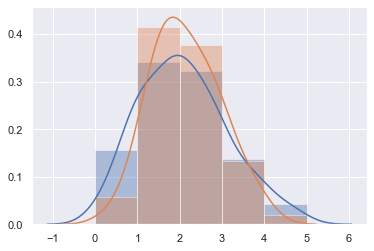

In [54]:
Draw.histogram(train_sr,test_sr)

What does stratification do to our data?

In [55]:
data = {"Original data":raw_data["output"],"Stratified data":list(test.settings.get_y_stratified(test.settings.y).ravel())}
df1 = pd.DataFrame(data = data)
df1.head(10)

,Original data,Stratified data
0,2.516485,2
1,1.640909,1
2,0.416348,0
3,1.338558,1
4,1.729517,1
5,2.704476,2
6,1.971622,1
7,1.843582,1
8,2.082107,2
9,2.898305,2


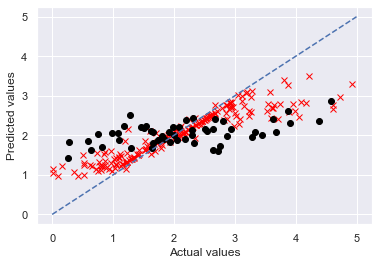

train_r2 0.7435736074469517
test_r2 0.1955238565470605


In [56]:
test.settings.set_stratify(True)
train_sr,test_sr = test.train_test("SVR")
Draw.scatterplot(train_sr,test_sr)
y_train,y_train_predicted = train_sr["y_train"],train_sr["y_train_predicted"]
y_test, y_test_predicted  = test_sr["y_test"], test_sr["y_test_predicted"]

print("train_r2",r2_score(y_train,y_train_predicted))
print("test_r2",r2_score(y_test,y_test_predicted))

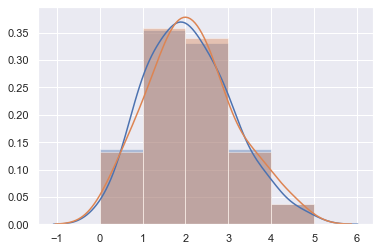

In [57]:
Draw.histogram(train_sr,test_sr)

We want to do better. Let's make bins [3-4] and [4-5] more significant in the training process

## 0.2.1 Manually increase bias towards higher yield

In [58]:
test.settings.set_bias(0.5)
test.settings.print_settings()

0.2 0.5 3


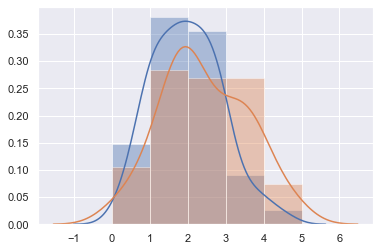

In [59]:
train_sr,test_sr = test.train_test("SVR")
Draw.histogram(train_sr,test_sr)

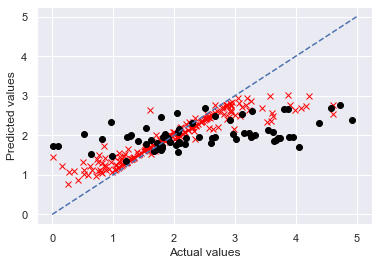

train_r2 0.7548894975663292
test_r2 0.06099091657936773


In [61]:
Draw.scatterplot(train_sr,test_sr)
y_train,y_train_predicted = train_sr["y_train"],train_sr["y_train_predicted"]
y_test, y_test_predicted  = test_sr["y_test"], test_sr["y_test_predicted"]

print("train_r2",r2_score(y_train,y_train_predicted))
print("test_r2",r2_score(y_test,y_test_predicted))

In [62]:
test.settings.print_settings()
train_avg,test_avg = test.R2_avg(["ADA","RFR","SVR","XGB"],5)
ss = ScoreSheet("Average Biased Split R2")
ss.add_score(train_avg)
ss.add_score(test_avg)
print(ss.title)
ss.get_sheet().head()


0.2 0.5 3
Average Biased Split R2


,ADA,RFR,SVR,XGB
Train R2,0.748274,0.813855,0.747230,1.00000
Test R2,0.016474,0.056977,0.019033,-0.01997


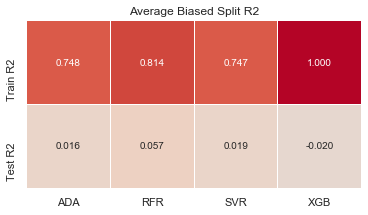

In [63]:
Draw.heatmap(ss)